In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(os.getcwd()+"/../../")

import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from ood_detection_helper import *

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
sns.set(style="darkgrid")

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.experimental.list_physical_devices('GPU'))
tf.__version__

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


'2.3.1'

## Loading OOD datasets

In [3]:
with open("train_scores.p", "rb") as f:
    train_scores = pickle.load(f)
print(train_scores.shape)

with open("scores.p", "rb") as f:
    inlier_scores = pickle.load(f).numpy()
inlier_scores.shape

(73000, 10)


(26000, 10)

In [4]:
with open("ood_scores.p", "rb") as f:
    ood_dict = pickle.load(f)
ood_dict.keys()

dict_keys(['LSUN', 'LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN', 'gaussian', 'uniform', 'cifar'])

In [5]:
outlier_scores = [x.numpy() for x in ood_dict.values()]
non_synthetic_images = ['LSUN','LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN']
outlier_scores.append(np.concatenate([ood_dict[n].numpy() for n in non_synthetic_images]))

In [6]:
ood_names = list(ood_dict.keys()) + ["All Images"]
ood_names, len(outlier_scores)

(['LSUN',
  'LSUN_resize',
  'Imagenet',
  'Imagenet_resize',
  'iSUN',
  'gaussian',
  'uniform',
  'cifar',
  'All Images'],
 9)

## Calculating Scores

In [7]:
LABELS = np.array(["Train", "SVHN", 'LSUN','LSUN_resize',
                   'Imagenet','Imagenet_resize','iSUN',"Gaussian", "Uniform", "CIFAR", "All Images"])
COLORS = sns.color_palette("bright")

In [8]:
all_samples = np.concatenate([inlier_scores, *outlier_scores[:-4]])

all_labels = [0] * len(inlier_scores)

for idx, ood in enumerate(outlier_scores[:-4]): #Skipping gauss and uniform
    all_labels += [idx+1]*len(ood)

captions = [LABELS[x+1] for x in all_labels]

all_samples.shape, len(all_labels), len(captions)

((74925, 10), 74925, 74925)

In [9]:
%%time
import umap

umapper = umap.UMAP(n_components = 3,
                    n_neighbors=15,
                    min_dist=0)

embedding = umapper.fit_transform(all_samples)


CPU times: user 25min 31s, sys: 3min 7s, total: 28min 38s
Wall time: 1min 15s


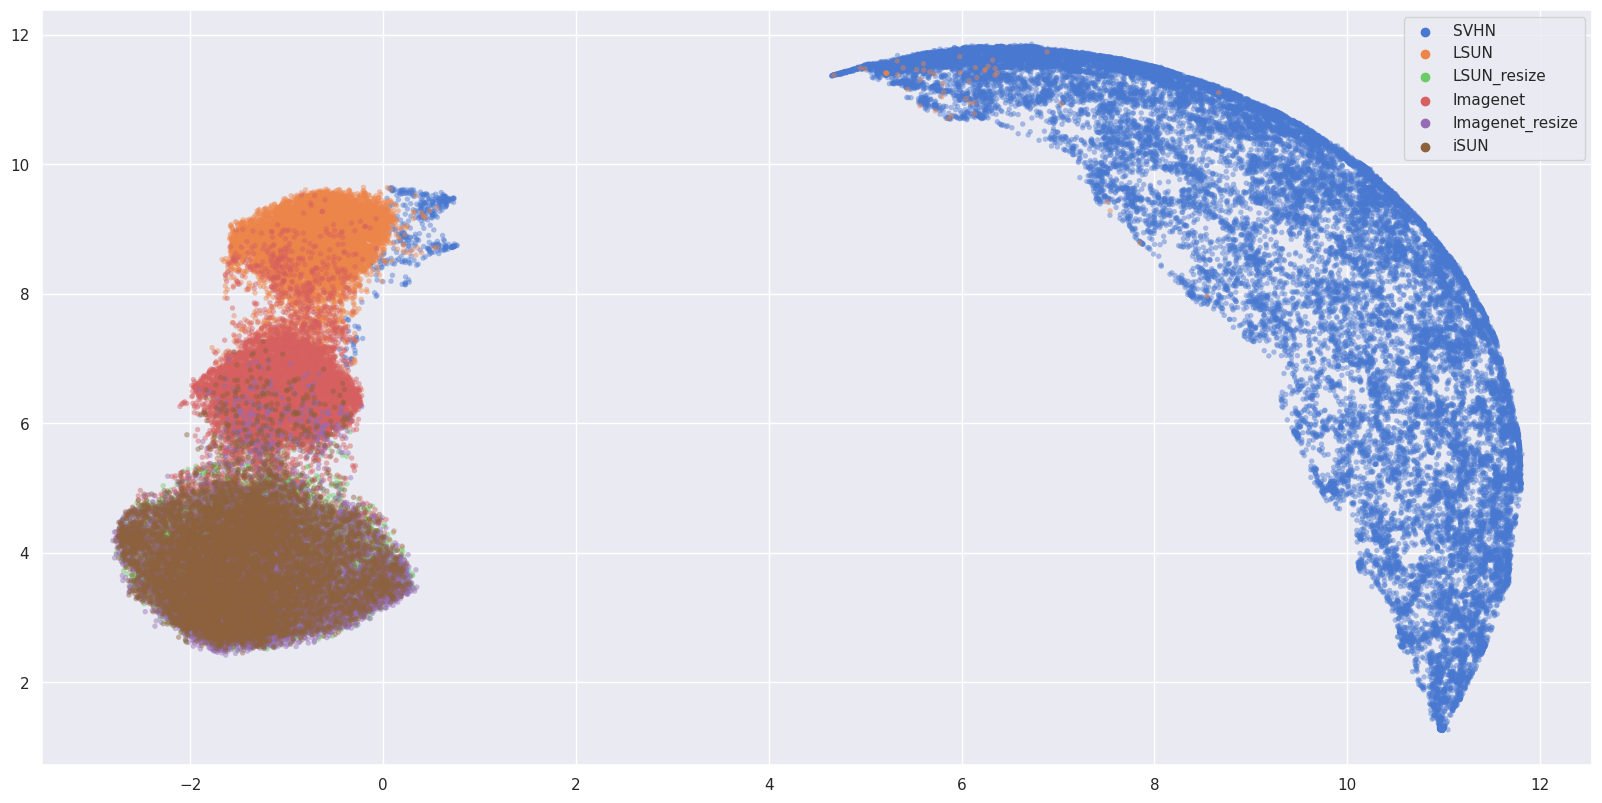

In [10]:
plot_embedding(embedding, all_labels, captions)

# Auxiliary model analysis

In [11]:
# Train Data = L2-norm(Pixel Scores)
X_train, X_test =  train_scores.copy(), inlier_scores.copy()

========================= Training GMM =========================
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   13.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  2.6min finished


Best: 5.797401 using {'GMM__covariance_type': 'full', 'GMM__n_components': 20}
---------------------------------------------------------------------------
5.317199 (0.034163) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
5.543961 (0.033303) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
5.654374 (0.033832) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 6}
5.694116 (0.034045) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 8}
5.715242 (0.033322) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 10}
5.748531 (0.030623) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 12}
5.762124 (0.031425) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 14}
5.779311 (0.031297) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 16}
5.792869 (0.030566) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 18}
5.797401 (0.027927) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 20}


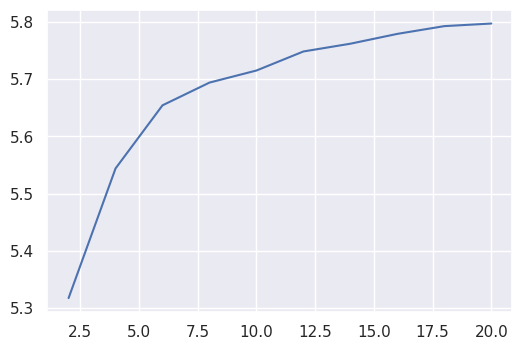

---Likelihoods---
Training: 5.826
SVHN: 5.455
LSUN: -1900.294
LSUN_resize: -1045.723
Imagenet: -1422.041
Imagenet_resize: -1742.084
iSUN: -1519.065
Gaussian: -2269.617
Uniform: -1435.789
CIFAR: -6.143
All Images: -1525.990
========================= Training Flow Model =========================
Epoch 1/1000
570/570 [==============================] - 3s 5ms/step - loss: 1980.9292 - val_loss: 771.5509
Epoch 2/1000
570/570 [==============================] - 2s 4ms/step - loss: 556.5960 - val_loss: 364.3035
Epoch 3/1000
570/570 [==============================] - 2s 4ms/step - loss: 317.1390 - val_loss: 246.4450
Epoch 4/1000
570/570 [==============================] - 2s 4ms/step - loss: 234.3237 - val_loss: 197.3782
Epoch 5/1000
570/570 [==============================] - 2s 4ms/step - loss: 204.6085 - val_loss: 182.3178
Epoch 6/1000
570/570 [==============================] - 2s 4ms/step - loss: 191.2421 - val_loss: 171.8169
Epoch 7/1000
570/570 [==============================] - 2s 3ms/step 

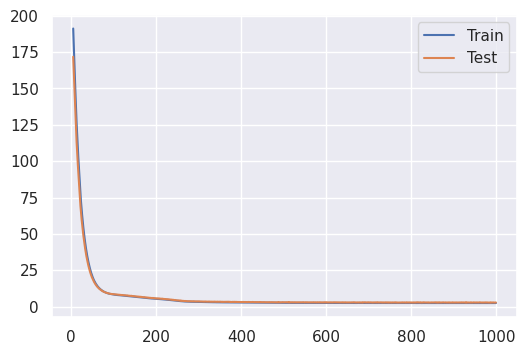

========================= Training KD Tree =========================
CPU times: user 1h 1min 12s, sys: 33min 44s, total: 1h 34min 57s
Wall time: 32min 9s


In [12]:
%%time
results = auxiliary_model_analysis(X_train, X_test, outlier_scores, LABELS, flow_epochs=1000)

In [24]:
TEST_IDX=8

## GMM

In [25]:
results["GMM"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
LSUN,0.000000,0.001923,100.000000,99.999999,100.000000,0.000000,99.999999
LSUN_resize,0.000000,0.006923,99.999997,99.999991,99.999999,0.000000,99.999991
Imagenet,0.000000,0.005769,99.999997,99.999993,99.999999,0.000000,99.999993
Imagenet_resize,0.000000,0.001923,99.999999,99.999998,100.000000,0.000000,99.999998
iSUN,0.000000,0.001923,99.999999,99.999996,100.000000,0.000000,99.999996
Gaussian,0.000000,0.000000,100.000000,100.000000,100.000000,0.000000,100.000000
Uniform,0.000000,0.000000,100.000000,100.000000,100.000000,0.000000,100.000000
CIFAR,9.119231,7.075385,97.598558,92.320308,99.144031,3.284615,92.321613
All Images,0.000000,0.003967,99.999998,99.999999,99.999997,0.000000,99.999999


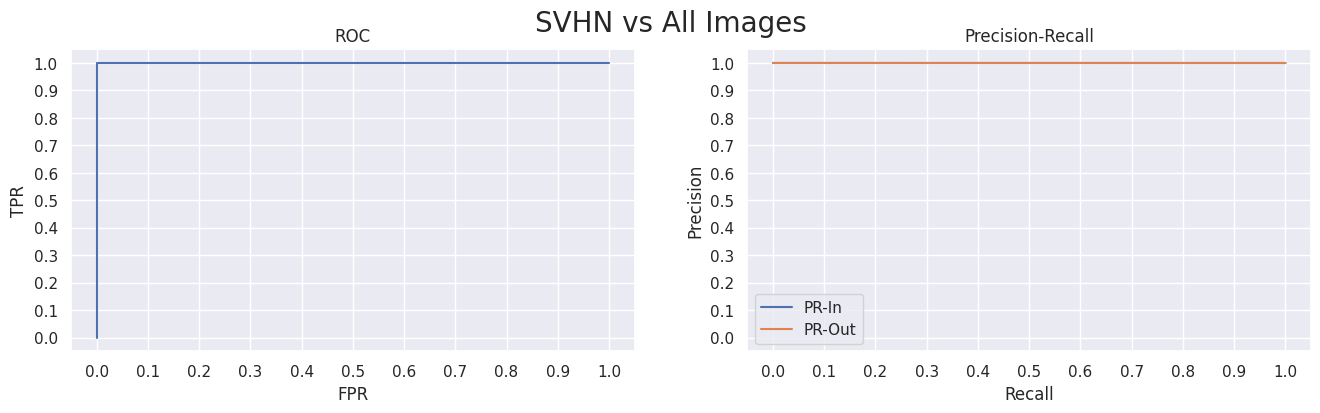

SVHN vs All Images
----------------
ROC-AUC: 100.0000
PR-AUC (In/Out): 100.0000 / 100.0000
FPR (95% TPR): 0.00%
Detection Error: 0.00%


{'fpr_tpr95': 0.0,
 'de': 3.967021736567051e-05,
 'roc_auc': 0.9999999827050823,
 'pr_auc_in': 0.9999999908085246,
 'pr_auc_out': 0.9999999674673917,
 'fpr_tpr80': 0.0,
 'ap': 0.9999999908086186}

In [26]:
ood_metrics(-results["GMM"]["test_scores"], -results["GMM"]["ood_scores"][TEST_IDX],
            names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

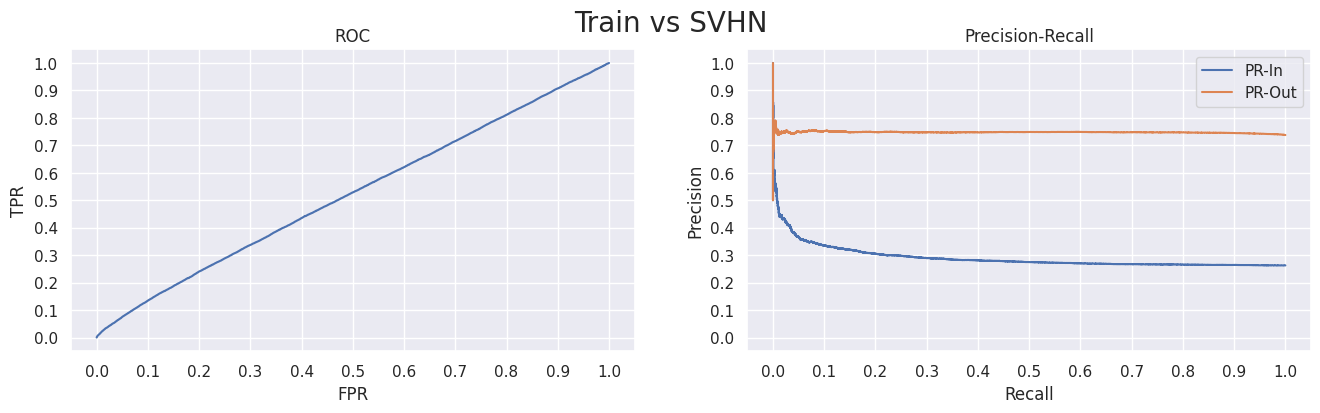

Train vs SVHN
----------------
ROC-AUC: 52.3467
PR-AUC (In/Out): 29.0722 / 74.7583
FPR (95% TPR): 94.58%
Detection Error: 47.97%


{'fpr_tpr95': 0.9458356164383561,
 'de': 0.47966991570073764,
 'roc_auc': 0.5234671027397261,
 'pr_auc_in': 0.290722301148604,
 'pr_auc_out': 0.7475826392963535,
 'fpr_tpr80': 0.7777945205479452,
 'ap': 0.2907652629250976}

In [27]:
ood_metrics(-results["GMM"]["train_scores"], -results["GMM"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## Flow Models

In [28]:
results["Flow"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
LSUN,0.000000,0.066154,99.999452,99.998571,99.999790,0.0,99.998571
LSUN_resize,0.000000,0.069615,99.998763,99.996749,99.999528,0.0,99.996749
Imagenet,0.000000,0.073462,99.999290,99.998145,99.999728,0.0,99.998145
Imagenet_resize,0.000000,0.061154,99.999489,99.998665,99.999804,0.0,99.998665
iSUN,0.000000,0.082191,99.999217,99.997709,99.999733,0.0,99.997709
Gaussian,0.000000,0.000000,100.000000,100.000000,100.000000,0.0,100.000000
Uniform,0.000000,0.000000,100.000000,100.000000,100.000000,0.0,100.000000
CIFAR,10.588462,7.818462,96.903981,88.193549,98.918563,4.0,88.201239
All Images,0.000000,0.074582,99.999243,99.999595,99.998612,0.0,99.999595


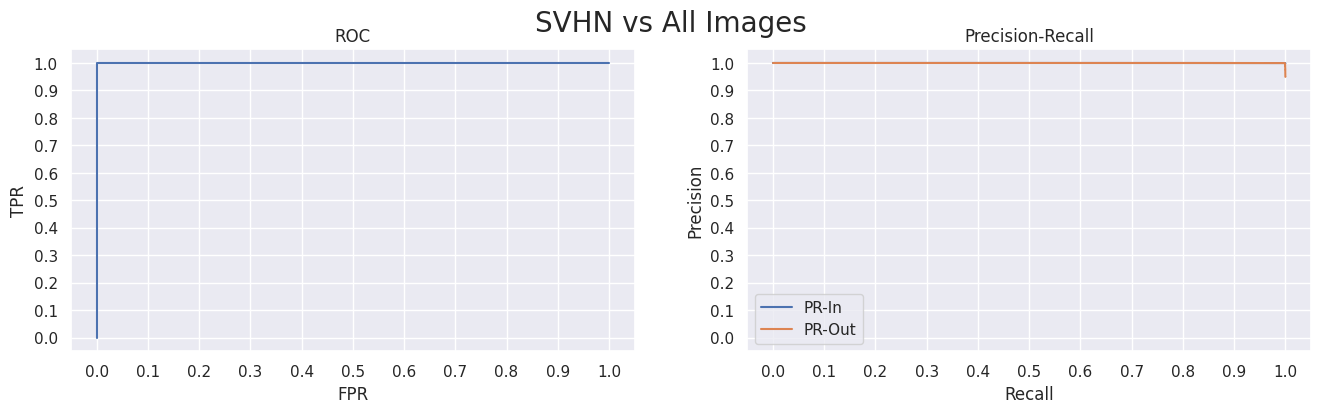

SVHN vs All Images
----------------
ROC-AUC: 99.9992
PR-AUC (In/Out): 99.9996 / 99.9986
FPR (95% TPR): 0.00%
Detection Error: 0.07%


{'fpr_tpr95': 0.0,
 'de': 0.0007458236704532096,
 'roc_auc': 0.9999924287567313,
 'pr_auc_in': 0.9999959483675532,
 'pr_auc_out': 0.9999861209835725,
 'fpr_tpr80': 0.0,
 'ap': 0.9999959484092508}

In [30]:
ood_metrics(-results["Flow"]["test_scores"], -results["Flow"]["ood_scores"][TEST_IDX],
            names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

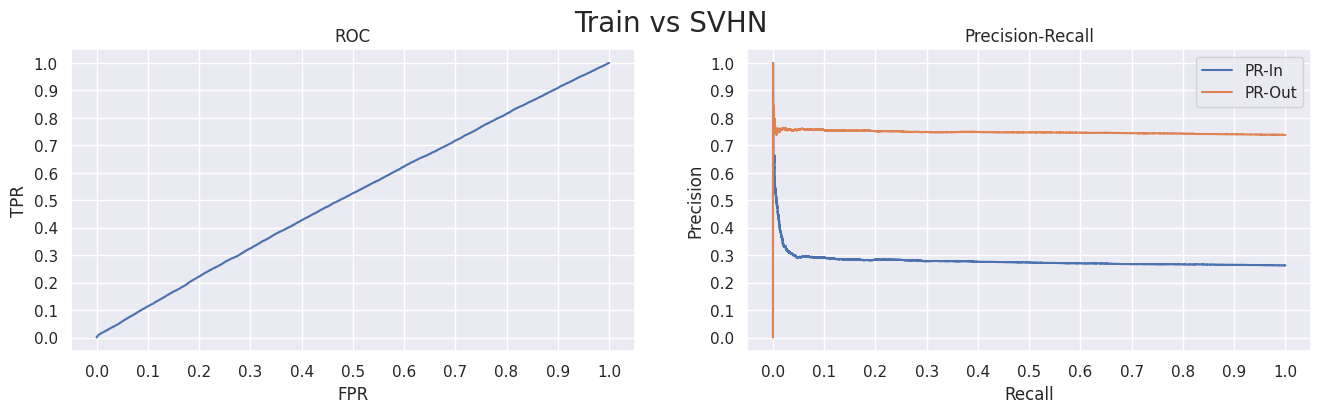

Train vs SVHN
----------------
ROC-AUC: 51.7905
PR-AUC (In/Out): 27.9086 / 74.7454
FPR (95% TPR): 94.26%
Detection Error: 48.59%


{'fpr_tpr95': 0.9425616438356165,
 'de': 0.485913856691254,
 'roc_auc': 0.5179049017386723,
 'pr_auc_in': 0.27908613881906275,
 'pr_auc_out': 0.7474543895754795,
 'fpr_tpr80': 0.7750410958904109,
 'ap': 0.27911862825246764}

In [31]:
ood_metrics(-results["Flow"]["train_scores"], -results["Flow"]["test_scores"],
            names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## KD Trees w/ k=5

In [32]:
results["KD"]["metrics"]

,fpr_tpr95,de,roc_auc,pr_auc_in,pr_auc_out,fpr_tpr80,ap
LSUN,0.042308,0.180385,99.992892,99.980165,99.997394,0.003846,99.980166
LSUN_resize,0.038462,0.108462,99.992515,99.978230,99.997317,0.011538,99.978232
Imagenet,0.046154,0.181538,99.990725,99.973260,99.996658,0.011538,99.973261
Imagenet_resize,0.011538,0.075769,99.998252,99.995329,99.999341,0.000000,99.995330
iSUN,0.023077,0.081857,99.996701,99.989862,99.998905,0.000000,99.989863
Gaussian,0.000000,0.000000,100.000000,100.000000,100.000000,0.000000,100.000000
Uniform,0.000000,0.000000,100.000000,100.000000,100.000000,0.000000,100.000000
CIFAR,8.469231,6.624231,97.630403,92.543656,99.155333,3.476923,92.544555
All Images,0.034615,0.146286,99.994163,99.996665,99.991043,0.003846,99.996665


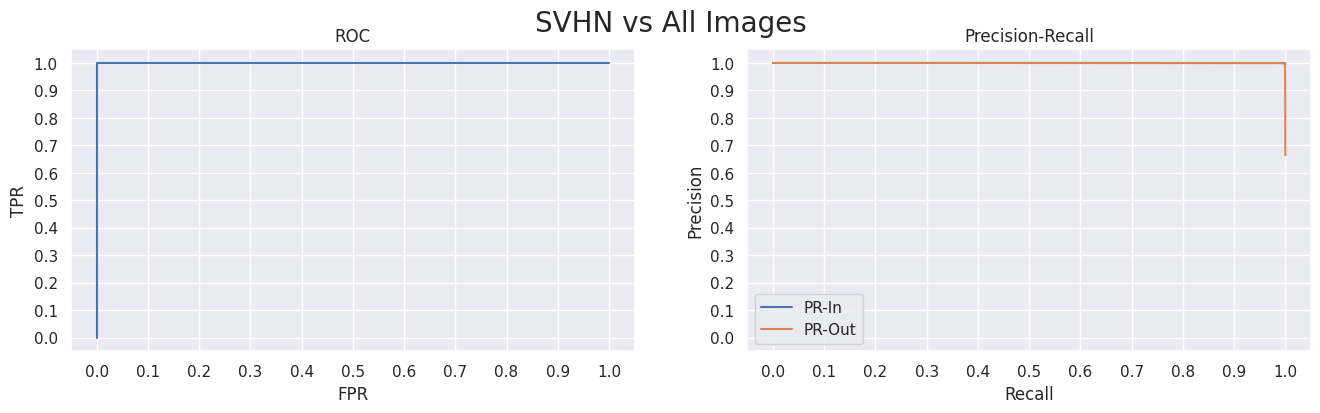

SVHN vs All Images
----------------
ROC-AUC: 99.9942
PR-AUC (In/Out): 99.9967 / 99.9910
FPR (95% TPR): 0.03%
Detection Error: 0.15%


{'fpr_tpr95': 0.00034615384615384613,
 'de': 0.0014628552336779371,
 'roc_auc': 0.9999416257222593,
 'pr_auc_in': 0.9999666536651759,
 'pr_auc_out': 0.9999104262414449,
 'fpr_tpr80': 3.846153846153846e-05,
 'ap': 0.9999666540334364}

In [33]:
ood_metrics(results["KD"]["test_scores"], results["KD"]["ood_scores"][TEST_IDX],
            names=(LABELS[1], LABELS[TEST_IDX+2]), plot=True, verbose=True)

### Validation Check

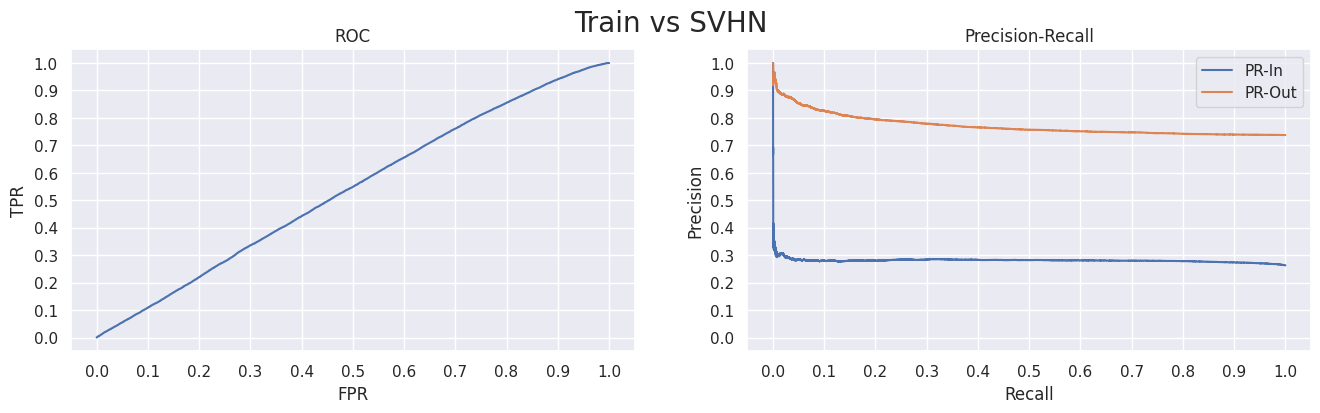

Train vs SVHN
----------------
ROC-AUC: 53.7531
PR-AUC (In/Out): 28.0684 / 77.1672
FPR (95% TPR): 91.20%
Detection Error: 46.90%


{'fpr_tpr95': 0.911958904109589,
 'de': 0.46897971548998946,
 'roc_auc': 0.5375311907270811,
 'pr_auc_in': 0.28068418639709664,
 'pr_auc_out': 0.7716721617266211,
 'fpr_tpr80': 0.7294931506849315,
 'ap': 0.28072060472015}

In [34]:
ood_metrics(results["KD"]["train_scores"], results["KD"]["test_scores"], names=(LABELS[0], LABELS[1]), plot=True, verbose=True)

## GMM vs Flow vs K-NN Tree

GMM ...
SVHN vs All
----------------
ROC-AUC: 99.6957
PR-AUC (In/Out): 99.8999 / 99.1440
FPR (95% TPR): 1.54%
Detection Error: 2.94%

Flow Model ...
SVHN vs All
----------------
ROC-AUC: 99.6073
PR-AUC (In/Out): 99.8703 / 98.9178
FPR (95% TPR): 2.20%
Detection Error: 3.31%

KD Tree ...
SVHN vs All
----------------
ROC-AUC: 99.6961
PR-AUC (In/Out): 99.8998 / 99.1503
FPR (95% TPR): 1.69%
Detection Error: 3.05%



Text(0.5, 0.98, 'Comparing Auxiliary Methods')

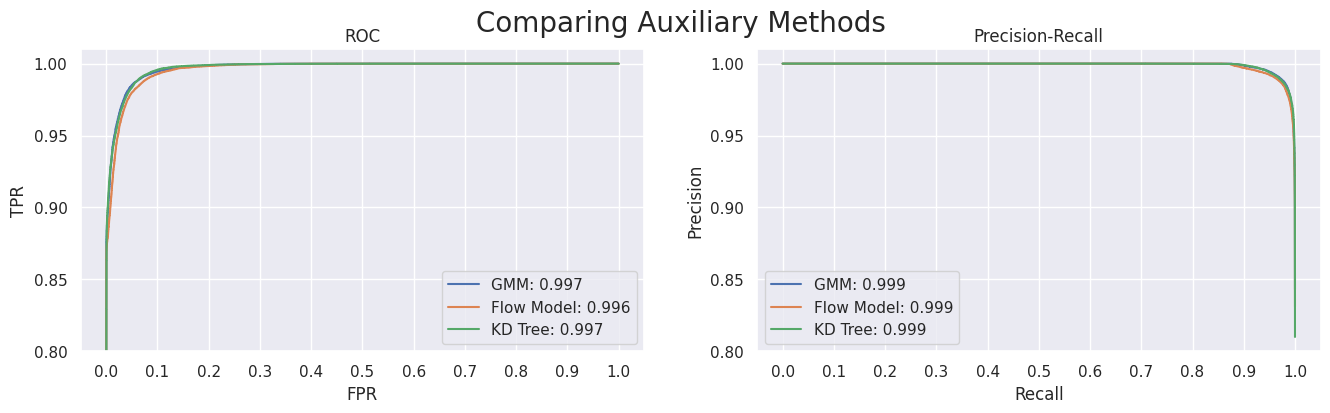

In [35]:
gmm_all = np.concatenate(-results["GMM"]["ood_scores"][:-1])
flow_all = np.concatenate(-results["Flow"]["ood_scores"][:-1])
kd_all = np.concatenate(results["KD"]["ood_scores"][:-1])

pairs = zip(
    ["GMM", "Flow Model", "KD Tree"],
    [-results["GMM"]["test_scores"], -results["Flow"]["test_scores"], results["KD"]["test_scores"]],
    [gmm_all, flow_all, kd_all]
)

fig, axs = plt.subplots(1,2, figsize=(16,4))

for title, cifar_scores, svhn_scores in pairs:
    print(title, "...")
    ood_metrics(cifar_scores, svhn_scores, names=("SVHN", "All"),plot=False, verbose=True)
    plot_curves(cifar_scores, svhn_scores, title, axs)
    print()

for ax in axs:
    ax.set(ylim=(0.8, 1.01), yticks=np.arange(0.8, 1.01, step=0.05))
axs[1].set(ylim=(0.8, 1.01))

plt.suptitle("Comparing Auxiliary Methods",  fontsize=20)
# plt.savefig("../../Figures/aux.png", dpi=200)